In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# Ejercicio de clasificación - Problema desbalanceado
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Ahora vamos a trabajar con un problema que se caracteriza por tener un gran desbalance de clases. Este tipo de situación es muy común en la práctica y requiere aplicar técnicas específicas para obtener buenos resultados. Existen múltiples estrategias para abordar estos casos, las cuales estudiarán en asignaturas posteriores. Entre ellas podemos mencionar:

- Uso de pesos en la función de pérdida (como `class_weight='balanced'`)
- Submuestreo de la clase mayoritaria (**undersampling**)
- Sobremuestreo de la clase minoritaria (**oversampling**)
- Técnicas de generación sintética de datos como **SMOTE**
- Algoritmos específicos para clases desbalanceadas (por ejemplo, `BalancedRandomForestClassifier`)

En este caso, vamos a usar un modelo de regresión logística, el cual será entrenado indicándole que se le dé mayor importancia a la clase minoritaria (que en general es la clase positiva, la que representa el evento poco frecuente).

Esto se logra ajustando la función de pérdida (la log-verosimilitud negativa) mediante un peso proporcional al desbalance de clases. En **scikit-learn**, este ajuste se realiza con el argumento `class_weight`, y la forma automática que aplicaremos es:

```python
class_weight='balanced'
```

**Entonces, ¿qué hace `'balanced'`?**

**Scikit-learn** calcula automáticamente los pesos para cada clase según la fórmula:

```python
peso_clase_i = n_muestras_totales / (n_clases * cantidad_de_muestras_de_clase_i)
```

Esto significa que:

- Si una clase aparece poco, su peso es mayor → el modelo *“escucha más fuerte”* a esas muestras.
- Si una clase aparece mucho, su peso es menor → su influencia se reduce, evitando que domine el aprendizaje.
- Al usarse un peso inversamente proporcional a la frecuencia de la clase, se compensa el desbalance, haciendo que el impacto total de cada clase en el entrenamiento sea más equilibrado.

**¿Qué logra este enfoque?**

Esto hace que el modelo:

- El modelo se penaliza más por equivocarse en la clase minoritaria.
- Aprende a distinguir mejor ambas clases.
- Generaliza mejor en datasets desbalanceados, evitando predecir siempre la clase mayoritaria.

---
### Descripción del problema

Vamos a estudiar un dataset que contiene información sobre el incumplimiento de pago por parte de clientes de una compañía de tarjetas de crédito.

De cada cliente se tiene:

- El saldo que se le facturó en la tarjeta (`balance`)
- Si es estudiante universitario o no (`student`)
- Su sueldo anual (`income`)
- Y si incumplió el pago (`default`), que será nuestra variable objetivo.

En este caso, la clase de interés (la clase positiva) es la de clientes que incumplen el pago, que representa una minoría dentro del conjunto de datos. Esto hace que el problema sea naturalmente desbalanceado, y por eso es un excelente caso para aplicar lo que aprendimos sobre el ajuste de pesos en modelos de clasificación.

In [23]:
default_df = pd.read_csv("./datasets/Default.csv")

### Exploración de los datos

Veamos un poco nuestros datos

In [24]:
default_df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [25]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


Vamos a convertir las columnas `default` y `student` en columnas numéricas y otras con nombres más legibles. Esto va a ser útil tanto para visualizaciones como para el modelo de regresión logística, que no permite variables categóricas directamente (a menos que se conviertan con one-hot encoding, pero en este caso usaremos la versión binaria).

In [26]:
default_df["Incumplimiento"] = default_df["default"].apply(lambda x: "Si" if x == "Yes" else "No")
default_df["Estudiante"] = default_df["student"].apply(lambda x: "Si" if x == "Yes" else "No")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

Tenemos 2 **columnas numéricas**, 1 **categórica**, y un **label categórico**. No hay valores faltantes. Veamos una breve descripción de los atributos y el label:

- `default`: Es la variable objetivo (label). Si es 1, significa que la persona incumplió el pago de la tarjeta.
- `student`: Variable categórica que indica si la persona es estudiante. Vale 1 si es estudiante y 0 si no lo es.
- `balance`: Monto del resumen de la tarjeta de crédito a pagar. 
- `income`: Ingreso anual de la persona titular de la tarjeta.

Veamos el balance de clases:

In [27]:
default_df.Incumplimiento.value_counts()

Incumplimiento
No    9667
Si     333
Name: count, dtype: int64

Observamos una gran desproporción de clases: solo el **3.3% de las observaciones** corresponde a personas que incumplieron. Este número tiene sentido; en general, la mayoría de las personas pagan sus deudas. Si este porcentaje fuera más alto, significaría que ofrecer tarjetas de crédito sería un muy mal negocio.

Podemos ajustar un poco el desbalance, ya que existen casos donde el `balance` de la tarjeta es cero, y todos esos están pagados:

In [28]:
default_df[default_df["balance"] == 0].Incumplimiento.value_counts()

Incumplimiento
No    499
Name: count, dtype: int64

Eliminamos esos casos:

In [29]:
default_df = default_df[default_df["balance"] != 0]
default_df.Incumplimiento.value_counts()

Incumplimiento
No    9168
Si     333
Name: count, dtype: int64

Ahora la proporción mejora **ligeramente a un 3.5%**, lo que sigue siendo muy desbalanceado, pero es un poco mejor.

#### Visualización de los datos


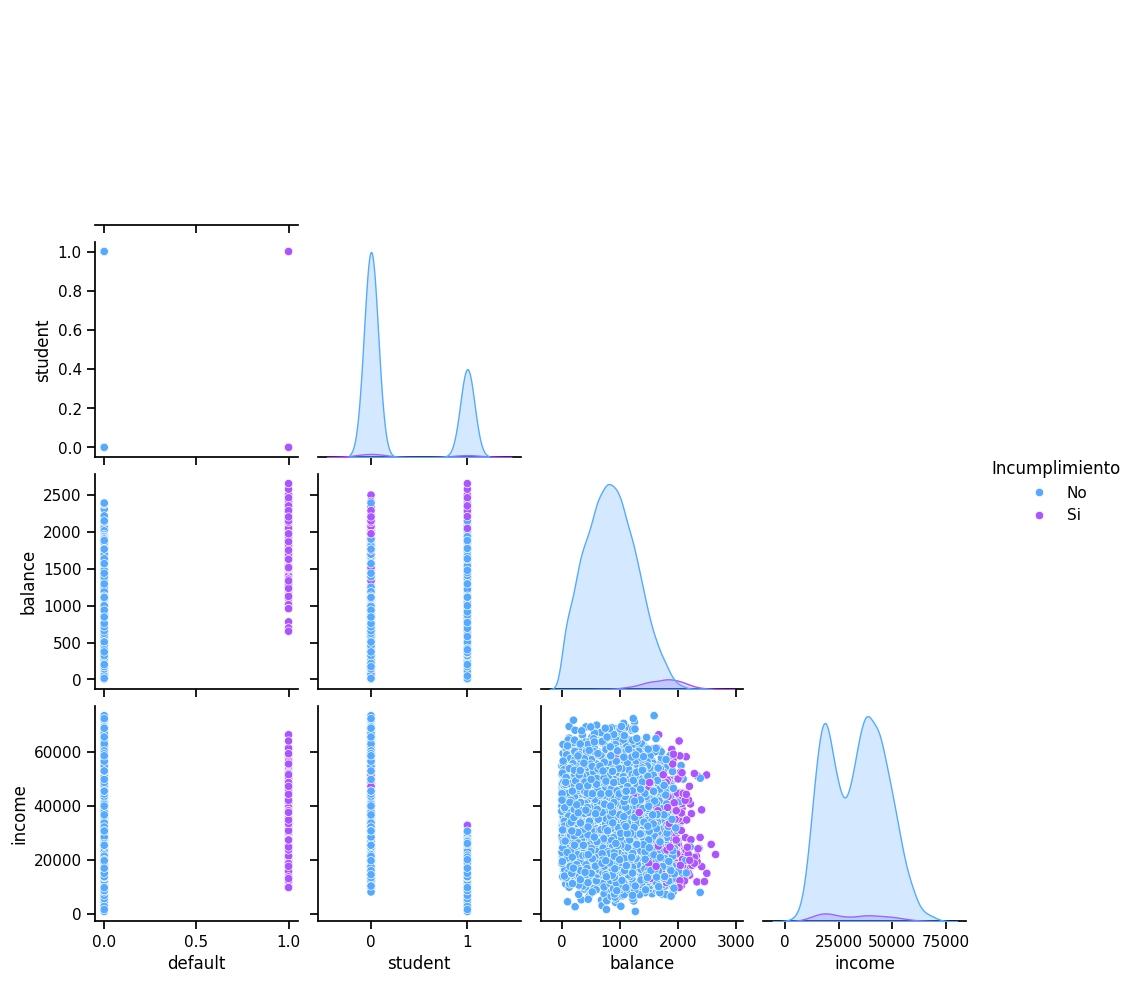

In [30]:
sns.pairplot(data=default_df, diag_kind="kde", hue="Incumplimiento", palette="cool", corner=True);

Veamos un gráfico de dispersión más detallado, codificando `student` con la forma del punto, y `default` con el color:

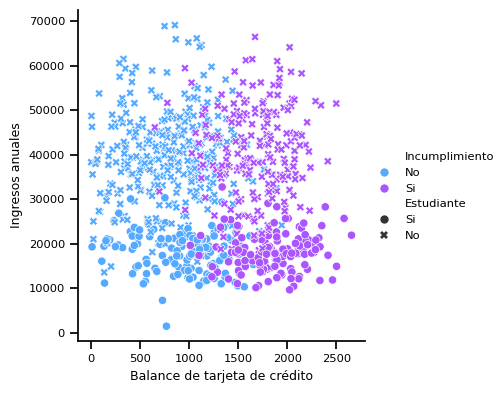

In [31]:
# Submuestreamos para facilitar la visualización
df_sample_no_default = default_df[default_df["default"] == 0].copy()
df_sample_no_default = df_sample_no_default.sample(frac=0.05)
df_sample_default = default_df[default_df["default"] == 1].copy()

sns.set_context("notebook", font_scale=0.75)
g = sns.relplot(data=pd.concat([df_sample_no_default, df_sample_default]), x="balance", y="income", 
                hue="Incumplimiento", style="Estudiante", kind="scatter", legend=True, palette="cool",
                height=4)
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("Ingresos anuales");

Observaciones del gráfico:
- Los estudiantes tienden a tener ingresos menores que los no estudiantes.
- La mayoría de los incumplimientos ocurren cuando el balance de la tarjeta es alto.
- A simple vista, el ingreso no parece ser un factor determinante en el incumplimiento.
- En los estudiantes, los incumplimientos tienden a aparecer en balances más altos comparado con los no estudiantes.

Veamos ahora diagramas de caja:

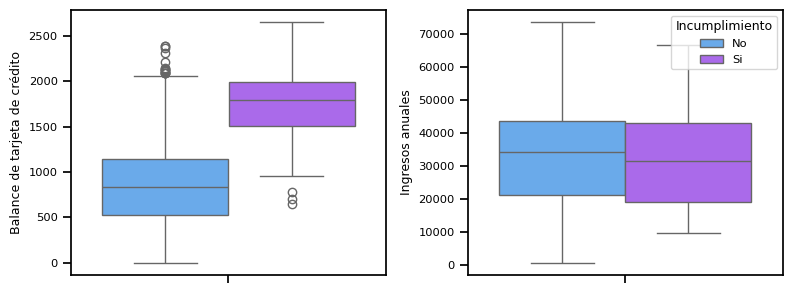

In [32]:
f, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=default_df, y="balance", hue="Incumplimiento", ax=ax[0], 
            palette="cool", legend=False)
sns.boxplot(data=default_df, y="income", hue="Incumplimiento", ax=ax[1], 
            palette="cool", legend=True)
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

Observaciones:
- Las personas que incumplen tienen balances notablemente más altos.
- Para los ingresos, aunque hay mucho solapamiento, la media del grupo que incumple parece más baja que la del grupo que paga.

Ahora analicemos el efecto de ser estudiante:

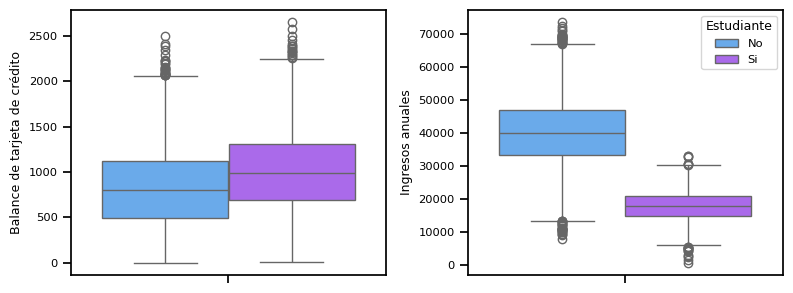

In [33]:
f, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=default_df, y="balance", hue="Estudiante", ax=ax[0], 
            palette="cool", legend=False)
sns.boxplot(data=default_df, y="income", hue="Estudiante", ax=ax[1], 
            palette="cool", legend=True)
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

Observaciones:
- Los estudiantes tienen ingresos claramente más bajos que los no estudiantes.
- Los balances de tarjeta de crédito tienden a ser más altos en estudiantes.

Analicemos la tasa de incumplimiento por nivel de balance y condición de estudiante:

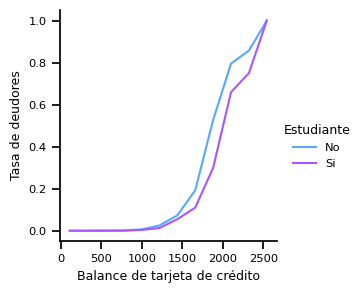

In [34]:
# Segmentamos el balance en bins
default_df["balance_bin"] = pd.cut(default_df['balance'], 12).apply(lambda x: x.mid)

df_grouped = default_df.groupby(["balance_bin", "student"], as_index=False, observed=True).agg({
    "default": ["sum", "count"] 
})
df_grouped.columns = ["balance", "Estudiante", "sum", "count"]
df_grouped["default_rate"] = df_grouped["sum"] / df_grouped["count"]

df_grouped["Estudiante"] = df_grouped["Estudiante"].apply(lambda x: "Si" if x == 1 else "No")

g = sns.relplot(data=df_grouped, x="balance", y="default_rate", hue="Estudiante", 
                kind="line", legend='auto', palette='cool', height=3)
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("Tasa de deudores");

¿Qué observamos?
- Dado un mismo nivel de balance, los estudiantes tienen una menor tasa de incumplimiento que los no estudiantes.

---
### Primer modelo de regresión logística usando `balance`

Podemos ver que la variable balance de tarjeta de crédito es la mejor candidata para clasificar si una persona va a pagar o no. Por lo tanto, armemos un modelo de regresión logística simple utilizando únicamente `balance`.

In [35]:
X = default_df[["balance"]]
y = default_df["default"]

Para no perder el delicado equilibrio entre clases, usamos el argumento `stratify` en la función `train_test_split`, así nos aseguramos de que ambos conjuntos (entrenamiento y testeo) mantengan la misma proporción de clases:

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, 
                                                    stratify=y)

Ya con los datos de entrenamiento, entrenamos un modelo de regresión logística de [sckit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), recordando que vamos a usar `class_weight="balanced"` para indicarle al modelo que compense automáticamente la diferencia entre clases durante el ajuste (esto se hace ajustando los pesos en la función de pérdida).

> 🧠 **Nota**: Aunque en este caso hay solo un atributo, vamos a usar un pipeline con preprocesamiento para aplicar el escalamiento. Esto es una buena práctica general para evitar problemas numéricos y mantener el flujo organizado.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocesamiento para la columna numérica
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["balance"])
    ]
)

# Pipeline: preprocesamiento + modelo
log_1_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0, class_weight="balanced"))
])

In [38]:
log_1_attr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance'])])),
                ('regressor',
                 LogisticRegression(class_weight='balanced', random_state=0))])

Más adelante vamos a evaluar este modelo. Por ahora, vamos a crear un par de modelos más.

----

### Modelo de regresión logística usando solamente `student`

Ahora apliquemos otro modelo de regresión logística, pero utilizando solo la variable categórica `student`, que ya está codificada como binaria. Esta variable parecía un buen candidato para predecir el incumplimiento, dado que en las visualizaciones vimos que los estudiantes, a igualdad de balance, tenían tasas de incumplimiento más bajas que los no estudiantes.

In [40]:
Xstudent = default_df[["student"]]
ystudent = default_df["default"]

(X_train_student, 
 X_test_student, 
 y_train_student, 
 y_test_student) = train_test_split(Xstudent, ystudent, test_size=0.25, random_state = 0, stratify=y)

# No es necesario escalar esta variable binaria
classifier_student = LogisticRegression(random_state = 0, class_weight="balanced")
classifier_student.fit(X_train_student, y_train_student)

LogisticRegression(class_weight='balanced', random_state=0)

Como `student` es una variable booleana, podemos ver la salida probabilística del modelo en ambos casos

In [44]:
student_input = pd.DataFrame({"student": [1]})
student_out = classifier_student.predict_proba(student_input)[0, -1]

no_student_input = pd.DataFrame({"student": [0]})
no_student_out = classifier_student.predict_proba(no_student_input)[0, -1]

print(f"La probabilidad de incumplimiento si es estudiante: {student_out}")
print(f"La probabilidad de incumplimiento si NO es estudiante: {no_student_out}")

La probabilidad de incumplimiento si es estudiante: 0.5645924181685545
La probabilidad de incumplimiento si NO es estudiante: 0.46567368825289035


**¿Qué está pasando?**

Vemos que si la persona es estudiante, el modelo le asigna mayor probabilidad de no pagar... ¡pero habíamos observado lo contrario en el análisis exploratorio!

Aunque un estudiante individual, con un saldo de tarjeta determinado, tiende a tener una menor probabilidad de incumplimiento que un no estudiante con el mismo balance, el hecho de que los estudiantes tienden a tener balances más altos en general, implica que en términos globales, los estudiantes incumplen más que los no estudiantes.

> 📌 En otras palabras:
> - Dado un mismo balance → el estudiante es menos riesgoso.
> - Sin considerar balance → el estudiante es más riesgoso.

Esto es una distinción muy importante para una compañía de tarjetas de crédito que intenta decidir a quién ofrecerle crédito. Un estudiante es más riesgoso si no se tiene en cuenta el balance, pero menos riesgoso si se controla por ese factor.

Este ejemplo ilustra un fenómeno conocido como factor de **confusión** o **confounder**.

> 🧠 **¿Qué es un factor de confusión?**
>
> Un factor de confusión es una variable que afecta simultáneamente a la variable independiente y a la dependiente, generando una relación espuria (aparentemente directa) entre ellas. Es decir, se observa una asociación que en realidad es causada por una tercera variable no considerada.
>
> 🍦 Ejemplo clásico: helados, crímenes y calor
>
> Supongamos que observamos los siguientes datos:
> - En verano, aumentan las ventas de helado.
> - En verano, también aumentan los índices de delincuencia.
> A simple vista, podríamos concluir: “¡Los helados provocan delitos!” 😱
>
> Pero eso sería incorrecto. El verdadero culpable es un tercer factor: **la temperatura**.
> - La temperatura influye en el consumo de helados.
> - La temperatura también influye en la actividad al aire libre (más gente en la calle) y puede favorecer situaciones propensas al crimen.
>
> Entonces, si no se considera el efecto de la temperatura, parecería haber una relación directa entre ventas de helado y crimen, cuando en realidad, ambas dependen de una tercera variable.

🔍 En resumen:

Cuando realizamos una regresión con una sola variable sin considerar otras que también son relevantes, podemos sacar conclusiones erróneas. Es por eso que siempre que sea posible debemos:

- Agregar todas **las variables relevantes** en el modelo.
- Evaluar relaciones condicionadas (por ejemplo: “si controlamos por balance, ser estudiante disminuye el riesgo”).

---
### Modelo de regresión logística con todos los atributos

Probemos ahora un modelo de regresión logística utilizando todas las variables disponibles del dataset.

In [45]:
X = default_df[["balance", "income", "student"]]
y = default_df["default"]

(X_train_total, 
 X_test_total, 
 y_train_total, 
 y_test_total) = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [46]:
# Armamos el preprocesador para escalar solo las variables numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["balance", "income"])
    ]
)

# Y luego el pipeline con regresión logística
log_3_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0, class_weight="balanced"))
])

log_3_attr.fit(X_train_total, y_train_total)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance', 'income'])])),
                ('regressor',
                 LogisticRegression(class_weight='balanced', random_state=0))])

## Métricas de evaluación

Empecemos por la métrica más básica: el [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), que mide el porcentaje de observaciones correctamente clasificadas.

In [47]:
print(f"Porcentaje de muestras bien clasificadas (solo balance): {(log_1_attr.score(X_test, y_test)*100)}%")
print(f"Porcentaje de muestras bien clasificadas (todos los atributos): {(log_3_attr.score(X_test_total, y_test_total)*100)}%")

Porcentaje de muestras bien clasificadas (solo balance): 85.77441077441077%
Porcentaje de muestras bien clasificadas (todos los atributos): 85.05892255892256%


A simple vista, ambos modelos parecen excelentes. Pero comparemos con un modelo naive que predice que todas las personas pagarán la tarjeta (es decir, siempre predice clase 0).

In [48]:
from sklearn.metrics import accuracy_score
prediccion_naive = np.zeros_like(y_test) 

print(f"Porcentaje de muestras bien clasificadas por el modelo naive: {accuracy_score(y_test, prediccion_naive)*100}%")

Porcentaje de muestras bien clasificadas por el modelo naive: 96.506734006734%


**¿Qué pasó? ¿Por qué el modelo naive parece tan bueno?**

Sencillo: en el dataset tenemos aproximadamente **9100 registros de personas que pagaron y 300 que no pagaron**. Es decir, un gran desbalance de clases, donde la clase positiva (no pagar) es mucho más pequeña que la negativa.

Esto hace que un modelo que siempre predice la clase mayoritaria tenga una alta precisión general (`accuracy`), pero en realidad no aprenda nada útil.

#### Matriz de confusión

Para evaluar mejor el rendimiento, usemos otras métricas que consideren el desbalance de clases. Comenzamos con la [**matriz de confusión**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#confusion-matrix) y medidas derivadas como **sensibilidad, especificidad y exactitud balanceada**.


In [49]:
from sklearn.metrics import confusion_matrix

def sens_spec(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return cm, sensitivity, specifity, balanced_accuracy

In [50]:
# Predicciones
y_pred_1_attr = log_1_attr.predict(X_test)
y_pred_3_attr = log_3_attr.predict(X_test_total)

In [51]:
# Métricas
(cm_1_attr,
 sensitivity_1_attr,
 specifity_1_attr,
 balanced_accuracy_1_attr) = sens_spec(y_test, y_pred_1_attr)

(cm_3_attr, 
 sensitivity_3_attr,
 specifity_3_attr,
 balanced_accuracy_3_attr) = sens_spec(y_test, y_pred_3_attr)

(cm_naive, 
 sensitivity_naive,
 specifity_naive,
 balanced_accuracy_naive) = sens_spec(y_test, prediccion_naive)

Graficamos las matrices:

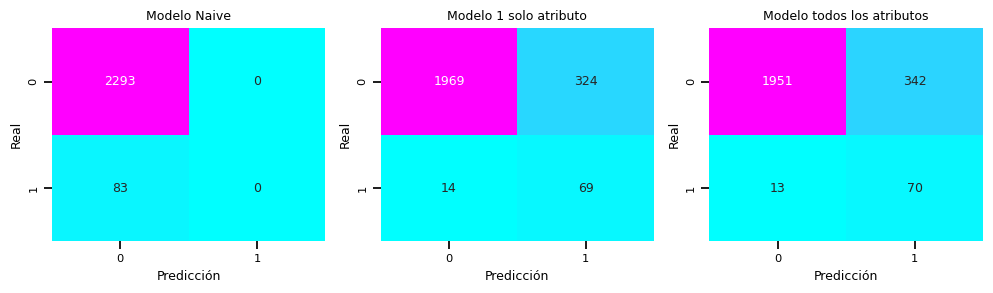

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

cms = [cm_naive, cm_1_attr, cm_3_attr]
titles = ["Modelo Naive", "Modelo 1 solo atributo", "Modelo todos los atributos"]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

In [53]:
print(titles[0])
print(f"Sensibilidad: {sensitivity_naive}")
print(f"Especificidad: {specifity_naive}")
print(f"Exactitud balanceada: {balanced_accuracy_naive}\n")

print(titles[1])
print(f"Sensibilidad: {sensitivity_1_attr}")
print(f"Especificidad: {specifity_1_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_1_attr}\n")

print(titles[2])
print(f"Sensibilidad: {sensitivity_3_attr}")
print(f"Especificidad: {specifity_3_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_3_attr}")

Modelo Naive
Sensibilidad: 0.0
Especificidad: 1.0
Exactitud balanceada: 0.5

Modelo 1 solo atributo
Sensibilidad: 0.8313253012048193
Especificidad: 0.8587003924989097
Exactitud balanceada: 0.8450128468518645

Modelo todos los atributos
Sensibilidad: 0.8433734939759037
Especificidad: 0.8508504143044047
Exactitud balanceada: 0.8471119541401542


La exactitud balanceada nos muestra que, en efecto, el modelo que predice que todos van a pagar la tarjeta está simplemente adivinando. Por otro lado, los dos modelos son muy similares en cuanto a métricas, lo que indica que agregar las columnas `student` e `income` no parece mejorar significativamente la capacidad predictiva del modelo.

#### Precisión y recuperación (recall)

Ahora veamos otras métricas útiles: precisión (precision) y recuperación (recall).

In [54]:
from sklearn.metrics import precision_score, recall_score

print(titles[0])
print(f"Precision: {precision_score(y_test, prediccion_naive, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, prediccion_naive, zero_division=0)}\n")

print(titles[1])
print(f"Precision: {precision_score(y_test, y_pred_1_attr)}")
print(f"Recuperación: {recall_score(y_test, y_pred_1_attr)}\n")

print(titles[2])
print(f"Precision: {precision_score(y_test_total, y_pred_3_attr)}")
print(f"Recuperación: {recall_score(y_test_total, y_pred_3_attr)}")

Modelo Naive
Precision: 0.0
Recuperación: 0.0

Modelo 1 solo atributo
Precision: 0.17557251908396945
Recuperación: 0.8313253012048193

Modelo todos los atributos
Precision: 0.16990291262135923
Recuperación: 0.8433734939759037


**Interpretación:**

En este caso, la clase positiva (persona que no paga la tarjeta) es la más importante, ya que detectar estos casos nos permite tomar acciones preventivas para reducir pérdidas financieras.

Por eso, nos interesa más la recuperación (recall) que la precisión (precision):

- **Recuperación**: cuántos de los que verdaderamente no pagaron fueron correctamente identificados.
- **Precisión**: cuántos de los que predijimos que no pagarían realmente no pagaron.

Debido al gran desbalance de clases, es común que la precisión sea baja: el modelo puede identificar algunos deudores, pero también puede equivocarse con muchos que sí iban a pagar.

> 👉 Aun así, es más costoso no detectar a una persona que no pagará (falso negativo), que predecir incorrectamente que alguien no pagará y sí lo haga (falso positivo).

Por eso, en este problema preferimos modelos que prioricen alta recuperación, incluso a costa de perder precisión.

#### Curva ROC

Obtengamos la curva ROC y el AUC.

In [55]:
# Nos quedamos con la clase positiva
prob_balance = log_1_attr.predict_proba(X_test)[:, -1]
prob_total = log_3_attr.predict_proba(X_test_total)[:, -1]
prob_naive = np.zeros_like(prob_total)

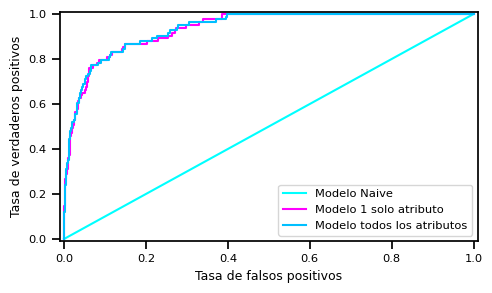

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_naive, tpr_naive, thr_naive = roc_curve(y_test, prob_naive)
fpr_balance, tpr_balance, thr_balance = roc_curve(y_test, prob_balance)
fpr_total, tpr_total, thr_total = roc_curve(y_test_total, prob_total)

colors = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

plt.figure(figsize=(5, 3))
plt.plot(fpr_naive, tpr_naive, label=titles[0], color=colors[0])
plt.plot(fpr_balance, tpr_balance, label=titles[1], color=colors[1])
plt.plot(fpr_total, tpr_total, label=titles[2], color=colors[3])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [57]:
auc_naive = roc_auc_score(y_test, prob_naive)
auc_balance = roc_auc_score(y_test, prob_balance)
auc_total = roc_auc_score(y_test, prob_total)

print(titles[0])
print(f"AUC: {auc_naive}\n")

print(titles[1])
print(f"AUC: {auc_balance}\n")

print(titles[2])
print(f"AUC: {auc_total}")

Modelo Naive
AUC: 0.5

Modelo 1 solo atributo
AUC: 0.9344994456675371

Modelo todos los atributos
AUC: 0.936243885266316


Vemos que los modelos que entrenamos presentan un AUC bastante alto, lo cual también se refleja en la forma de la curva ROC. Por otro lado, se confirma nuevamente que el modelo naive actúa como si estuviera eligiendo al azar, ya que su AUC es exactamente 0.5.

Entre los modelos entrenados, el mejor resulta ser el que utiliza solo el atributo `balance`, ya que nos brinda métricas muy similares al modelo que usa los tres atributos, pero con menor complejidad. Claramente, las variables `income` y `student` no aportan tanta información adicional como balance.

### Búsqueda del mejor threshold

Por último, vamos a analizar la curva ROC del modelo entrenado con un solo atributo. La idea es quedarnos con el valor de threshold (umbral) que esté más cerca, en términos de distancia euclidiana, del punto de **clasificación perfecta (0, 1)**. Este punto representa el mejor equilibrio entre *Falsos Positivos* y *Verdaderos Positivos*.

> 🧠 **Nota**: Otra estrategia común para encontrar el mejor umbral es el índice de Youden (J), que maximiza la diferencia `tpr - fpr`, es decir, busca el punto donde la sensibilidad es mucho mayor que la tasa de falsos positivos.

In [59]:
# Distancia euclidiana al punto (0, 1)
distancias = np.sqrt((fpr_balance - 0)**2 + (tpr_balance - 1)**2)

# Índice del threshold óptimo
idx_optimo = np.argmin(distancias)

# Threshold óptimo
threshold_optimo = thr_balance[idx_optimo]

print(f"📌 Threshold óptimo (mínima distancia a (0,1)): {threshold_optimo:.4f}")

📌 Threshold óptimo (mínima distancia a (0,1)): 0.4847


> ⚠️ **Nota**: El threshold óptimo es cercano a 0.5, por lo que no esperamos mejoras drásticas en las métricas.

Graficamos la curva ROC y marcamos el punto óptimo:

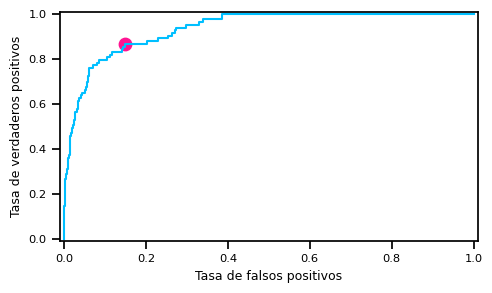

In [60]:
colors = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

plt.figure(figsize=(5, 3))
plt.plot(fpr_balance, tpr_balance, color=colors[3])
plt.scatter(fpr_balance[thr_balance==threshold_optimo], 
            tpr_balance[thr_balance==threshold_optimo], color=colors[2], s=80)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.tight_layout();

Ahora, con ese valor, podemos calcular las nuevas predicciones:

In [61]:
y_pred_custom = (prob_balance >= threshold_optimo).astype(int)

Comparemos los resultados usando el reporte de clasificación:

In [62]:
from sklearn.metrics import classification_report

print("Umbral no optimizado")
print(classification_report(y_test, y_pred_1_attr, digits=4))

print("Umbral optimizado")
print(classification_report(y_test, y_pred_custom, digits=4))

Umbral no optimizado
              precision    recall  f1-score   support

           0     0.9929    0.8587    0.9210      2293
           1     0.1756    0.8313    0.2899        83

    accuracy                         0.8577      2376
   macro avg     0.5843    0.8450    0.6054      2376
weighted avg     0.9644    0.8577    0.8989      2376

Umbral optimizado
              precision    recall  f1-score   support

           0     0.9944    0.8522    0.9178      2293
           1     0.1752    0.8675    0.2915        83

    accuracy                         0.8527      2376
   macro avg     0.5848    0.8598    0.6046      2376
weighted avg     0.9658    0.8527    0.8959      2376



El umbral optimizado mejora la **recuperación (recall)**, a costa de perder un poco de **precisión**, aunque la pérdida es mínima. El **puntaje F1** también mejora, lo que indica que hay un mejor equilibrio entre **precisión** y **recuperación**.

Eso sí, este nuevo umbral optimizado disminuye el puntaje F1 en la clase negativa, ya que ahora el modelo comete más falsos positivos. Sin embargo, si nuestro interés está principalmente en detectar correctamente a quienes no pagarán la tarjeta, este intercambio puede ser favorable desde una perspectiva de negocio.